- [Important Jargon](#Important-Jargon)
- [What Are Options?](#What-Are-Options?)
- [What Is the Black\-Scholes Option Pricing Model?](#What-Is-the-Black-Scholes-Option-Pricing-Model?)
- [\(Some of\) the Math](#(Some-of)-the-Math)
- [Black\-Scholes Formula in Python](#Black-Scholes-Formula-in-Python)
- [The Greeks](#The-Greeks)
- [The Greeks in Python](#The-Greeks-in-Python)
- [Realized Volatility](#Realized-Volatility)
- [Implied Volatility](#Implied-Volatility)
- [Getting Real Options Market Data](#Getting-Real-Options-Market-Data)
- [Applying Implied Volatility](#Applying-Implied-Volatility)
- [Interpolating Missing and Bad Implied Volatility Values](#Interpolating-Missing-and-Bad-Implied-Volatility-Values)
- [Applying Black\-Scholes and the Greeks](#Applying-Black-Scholes-and-the-Greeks)
- [Analyzing the Model Error](#Analyzing-the-Model-Error)
- [Analyzing Implied Volatility](#Analyzing-Implied-Volatility)
- [Conclusion](#Conclusion)
- [References  
  ](#References)



- <u>**Jargon important**</u>

**Option d'achat**. Contrat dérivé qui confère à l'acheteur de l'option le droit \(et non l'obligation\) d'acheter l'action sous\-jacente à un prix déterminé à une certaine date \(style européen\) ou avant une certaine date \(style américain\).

**Option de vente**. Contrat dérivé qui confère le droit \(et non l'obligation\) à l'acheteur de l'option de vendre l'action sous\-jacente à un prix déterminé à une date donnée.

**Dans la monnaie**. Condition dans laquelle le prix de l'action est supérieur au prix d'exercice pour une option d'achat ou inférieur au prix d'exercice pour une option de vente.

**Hors de la monnaie**. Le contraire de dans la monnaie.

**À la monnaie**. Le prix de l'action est égal \(ou très proche\) du prix d'exercice. Généralement considérée comme l'option dont le prix d'exercice est le plus proche de la monnaie.

**Volatilité réalisée**. Également appelée volatilité statistique ou historique, il s'agit généralement de l'écart\-type annualisé des rendements logarithmiques du sous\-jacent sur une période passée.

- <u>**Paramètres d'entrée pour fixer le prix des options**</u>

Les options dont le prix est calculé selon la méthode Black\-Scholes comportent cinq variables d'entrée, dont quatre peuvent être observées sur le marché et une est latente \(non observable, nous y reviendrons\).

**Prix de l'action sous\-jacente \(S\)**. Prix de l'action sous\-jacente dont dépend la valeur de l'option.

**Prix d'exercice \(K\)**. Prix auquel le détenteur de l'option peut acheter le sous\-jacent dans le cas d'un call ou vendre le sous\-jacent dans le cas d'un put.

**Délai d'expiration \(t\)**. Te  
ps \(en fraction d'une année de 365 jours\) jusqu'à l'expiration de l'option.

**Taux sans risque \(r\).** Taux dit "sans risque" \(mieux décrit comme le taux d'intérêt que vous obtiendriez avec un titre sans risque pendant la période de détention de l'option\).

**Volatilité \(vol\)**. La volatilité \(ou plus généralement la volatilité implicite\) est une valeur latente qui n'est pas observée sur le marché.



In [1]:
import time
import datetime as dt
from math import sqrt, pi

import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from openbb import obb
obb.user.preferences.output_type = "dataframe"

import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings("ignore")
print(
    f"Numpy {np.__version__}\nMatplotlib {mat.__version__}\nScipy {scipy.__version__}\nPandas {pd.__version__}"
)
print(obb)

Numpy 1.23.5
Matplotlib 3.8.3
Scipy 1.11.4
Pandas 2.2.0
OpenBB Platform v4.1.2

Utilities:
    /account
    /user
    /system
    /coverage

Routers:
    /commodity
    /crypto
    /currency
    /derivatives
    /econometrics
    /economy
    /equity
    /etf
    /fixedincome
    /index
    /news
    /quantitative
    /regulators
    /technical

Extensions:
    - commodity@1.0.0
    - crypto@1.1.2
    - currency@1.1.2
    - derivatives@1.1.2
    - econometrics@1.1.2
    - economy@1.1.2
    - equity@1.1.2
    - etf@1.1.2
    - fixedincome@1.1.2
    - index@1.1.2
    - news@1.1.2
    - openbb_charting@1.1.1
    - quantitative@1.1.2
    - regulators@1.1.2
    - technical@1.1.3

    - alpha_vantage@1.1.2
    - benzinga@1.1.2
    - biztoc@1.1.2
    - cboe@1.1.2
    - ecb@1.1.2
    - federal_reserve@1.1.2
    - finra@1.1.2
    - finviz@1.0.1
    - fmp@1.1.2
    - fred@1.1.2
    - government_us@1.1.2
    - intrinio@1.1.2
    - nasdaq@1.1.3
    - oecd@1.1.2
    - polygon@1.1.2
    - sec@1.1.2


# Options

Les options sont des contrats dérivés standardisés qui confèrent à l'acheteur le droit \(mais non l'obligation\) d'acheter le titre sous\-jacent dans le cas d'une option d'achat ou de vendre le titre sous\-jacent dans le cas d'une option de vente à un prix donné avant une date donnée \(pour les options de style américain\) ou à une date donnée \(pour les options de style européen\).

Il existe de nombreux types d'options, dont quelques\-uns seulement sont accessibles aux particuliers. Il existe des "exotiques" qui sont généralement des transactions de grande envergure \(des millions de dollars américains\) et qui sont négociées entre les banques d'investissement. Ces options sont généralement conçues sur mesure par des experts pour aider à résoudre les problèmes financiers spécifiques d'un client.

Nous nous concentrerons sur les options sur actions classiques, de style européen, afin de pouvoir utiliser la célèbre formule d'évaluation de Black\-Scholes. Nous reviendrons plus tard sur Black\-Scholes.

La plupart des produits dérivés ont une fonction de paiement qui décrit la valeur à la fin de la durée de vie du contrat \(expiration\). Pour une option d'achat, le gain peut être exprimé simplement comme suit :  

> $$C(S, K) = max(S-K, 0)$$

Alors que le gain d'une option de vente peut être exprimé comme suit :

> $$P(K, S) = max(K-S, 0)$$

Où _**S**_ et _**K**_ sont définis ci\-dessus. Dans ce cas, K reste fixe pendant la durée du contrat alors que le prix de l'action sous\-jacente, S, fluctue.

À partir d'une gamme de valeurs potentielles de S, nous pouvons former ce qui est communément appelé le payoff \(ou profil de risque ou graphique PnL\) d'une option à l'expiration.

Le défi pour les experts consiste à détermin  
er le prix de l'option avant l'expiration. C'est là qu'interviennent les modèles d'évaluation des options tels que Black\-Scholes.


In [2]:
# underlying stock price
S = 45.0

# series of underlying stock prices to demonstrate a payoff profile
S_ = np.arange(35.0, 55.0, 0.01)

# strike price
K = 45.0

# time to expiration (you'll see this as T-t in the equation)
t = 164.0 / 365.0

# risk free rate (there's nuance to this which we'll describe later)
r = 0.02

# volatility (latent variable which is the topic of this talk)
vol = 0.25

# black scholes prices for demonstrating trades
atm_call_premium = 3.20
atm_put_premium = 2.79

otm_call_premium = 1.39
otm_put_premium = 0.92

In [3]:
# use a lambda for a payoff functions
# equivelant to:
#
# def call_payoff(S, K):
#     return np.maximum(S - K, 0.0)
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)

# equivelant to:
#
# def put_payoff(S, K):
#     return np.maximum(K - S, 0.0)
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

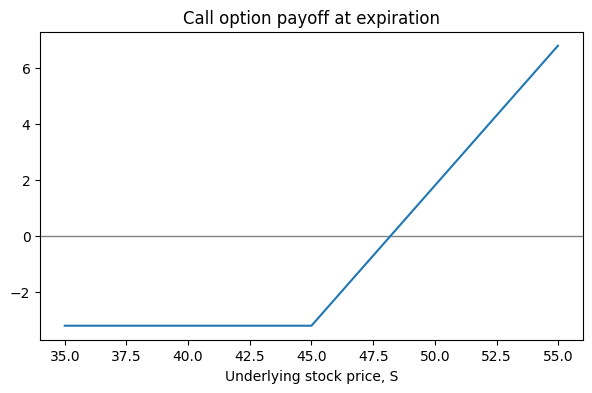

In [4]:
# plot the call payoff
plt.figure(1, figsize=(7, 4))
plt.title("Call option payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_call_premium + call_payoff(S_, K))

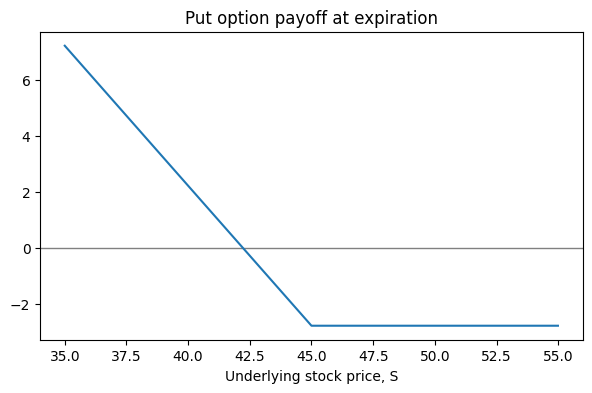

In [5]:
# plot the put payoff
plt.figure(2, figsize=(7, 4))
plt.title("Put option payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_put_premium + put_payoff(S_, K))

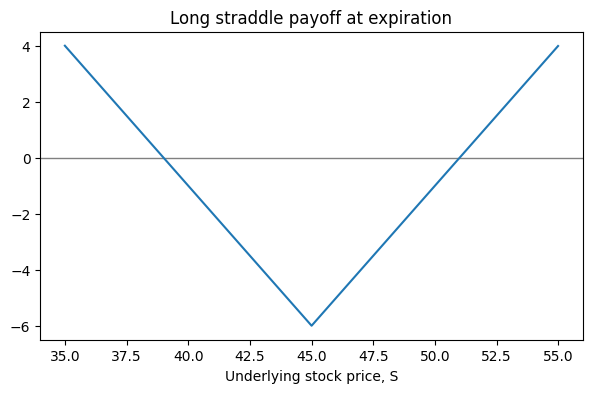

In [6]:
# plot a long straddle payoff
long_straddle = call_payoff(S_, K) + put_payoff(S_, K)
long_straddle_premium = -atm_call_premium - atm_put_premium
plt.figure(3, figsize=(7, 4))
plt.title("Long straddle payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, long_straddle_premium + long_straddle)

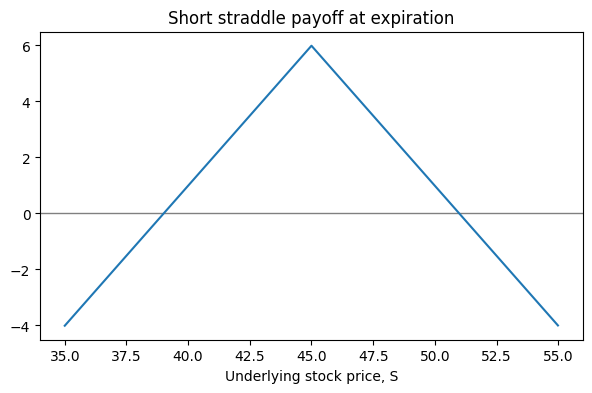

In [7]:
# plot a short straddle payoff
short_straddle = -call_payoff(S_, K) - put_payoff(S_, K)
short_straddle_premium = atm_call_premium + atm_put_premium
plt.figure(4, figsize=(7, 4))
plt.title("Short straddle payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_straddle_premium - long_straddle)

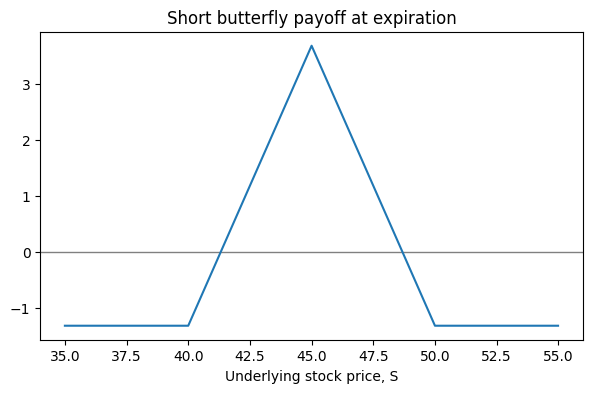

In [8]:
# plot a short butterfly payoff
short_butterfly = (
    call_payoff(S_, K + 5)
    - call_payoff(S_, K)
    - put_payoff(S_, K)
    + put_payoff(S_, K - 5)
)
short_butterfly_premium = (
    -otm_call_premium + atm_call_premium + atm_put_premium - otm_put_premium
)
plt.figure(5, figsize=(7, 4))
plt.title("Short butterfly payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_butterfly_premium + short_butterfly)

# Black\-Scholes Option Pricing Model

Black\-Scholes est largement considéré comme une formule d'évaluation des options, mais il s'agit en réalité d'un cadre qui modélise un marché financier. Dans ce cadre, la formule d'évaluation des options est dérivée de la différenciation stochastique.

Le modèle de Black\-Scholes suppose que le marché se compose d'au moins un actif risqué, généralement appelé action, et d'un actif sans risque, généralement appelé marché monétaire, liquidités ou obligations.

Hypothèses sur le marché :

Le taux de rendement de l'actif sans risque est constant et s'appelle donc le taux d'intérêt sans risque

Le logarithme instantané du rendement du cours de l'action est une marche aléatoire infinitésimale avec dérive et volatilité \(mouvement brownien géométrique\) et on suppose que cette dérive et cette volatilité sont constantes.

L'action ne verse pas de dividende

Hypothèses sur le titre sous\-jacent :

- Il n'y a pas d'opportunité d'arbitrage \(c'est\-à\-dire qu'il n'y a pas moyen de faire un profit sans risque\).
- Il est possible d'emprunter et de prêter n'importe quel montant, même fractionnaire, de liquidités au taux sans risque.
- Il est possible d'acheter et de vendre n'importe quel montant, même fractionnaire, de l'action \(y compris la vente à découvert\).
- Les transactions susmentionnées n'entraînent ni frais ni coûts \(c'est\-à\-dire un marché sans friction\).

Comme tout trader le sait, aucune de ces hypothèses ne se vérifie dans la réalité. La plus importante est probablement l'hypothèse de volatilité constante qui motive cette présentation.

Supposons que ces hypothèses se vérifient et qu'un titre dérivé soit également négocié sur ce marché. Nous spécifions que ce titre aura un certain gain à une date donnée dans le futur, en fonction de la \(des\) valeur\(s\) prise\(s\) par l'action jusqu'à cette date. Il est surprenant de consta  
ter que le prix du produit dérivé est entièrement déterminé à l'heure actuelle, même si nous ne savons pas quelle sera la trajectoire du prix de l'action à l'avenir. \(Pour le cas particulier d'une option européenne d'achat ou de vente, Black et Scholes ont montré qu'"il est possible de créer une position couverte, consistant en une position longue sur l'action et une position courte sur l'option, dont la valeur ne dépendra pas du prix de l'action". Leur stratégie de couverture dynamique a conduit à une équation aux dérivées partielles qui régit le prix de l'option. Sa solution est donnée par la formule de Black\-Scholes.


<u>_**\(Une partie\) des mathématiques**_</u>  


Le célèbre modèle Black\-Scholes :

> $$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0$$

L'idée financière clé qui sous\-tend l'équation est qu'il est possible de couvrir parfaitement l'option en achetant et en vendant l'actif sous\-jacent de la bonne manière et en créant ainsi un environnement sans arbitrage. Cette couverture implique à son tour qu'il n'y a qu'un seul prix correct pour l'option, comme l'indique la formule de Black\-Scholes. Pour que cette couverture dynamique fonctionne, il faut couvrir en permanence les mouvements de l'action sous\-jacente avec l'option, ce qui, en réalité, est prohibitif en raison des coûts de transaction.

Je passerai sur la dérivation des formules de prix des options à partir de l'équation différentielle partielle, mais le résultat se résout pour une option d'achat

> $$C(S, t) = N(d_{1})S - N(d_{2})Ke^{-r(T-t)}$$

et pour une option de vente

> $$P(S, t) = N(-d_{2})Ke^{-r(T-t)} - N(-d_{1})S$$

où

> $$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}$$

et

> $$d_{2} = d_{1} - \sigma\sqrt{T-t}$$

les paramètres sont définis comme suit : 

- N\(.\) est la fonction de distribution cumulative de la distribution normale standard
- T \- t est le temps à courir jusqu'à l'échéance \(j'utilise t dans le code\)
- S est le prix au comptant de l'actif sous\-jacent
- K est le prix d'exercice
- r est le taux sans risque \(taux annuel, exprimé en termes de composition continue\)
- σ est la volatilité des rendements de l'actif sous\-jacent \(j'utilise vol dans le code\)



# Black\-Scholes Formula in Python



In [9]:
def N(z):
    """ Normal cumulative density function

    :param z: point at which cumulative density is calculated 
    :return: cumulative density under normal curve
    """
    return norm.cdf(z)


def black_scholes_call_value(S, K, r, t, vol):
    """ Black-Scholes call option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    return N(d1) * S - N(d2) * K * np.exp(-r * t)


def black_scholes_put_value(S, K, r, t, vol):
    """ Black-Scholes put option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S

In [10]:
call_value = black_scholes_call_value(S, K, r, t, vol)
put_value = black_scholes_put_value(S, K, r, t, vol)

print(f"Black-Scholes call value {call_value:.2f}")
print(f"Black-Scholes put value {put_value:.2f}")

Black-Scholes call value 3.20
Black-Scholes put value 2.79


Comme nous avons vectorisé la fonction, nous pouvons représenter la valeur de l'option d'achat Black\-Scholes sur une plage de prix de l'action sous\-jacente. Revenons à notre exemple de la valeur de l'option à l'échéance. Voyons ce qu'il en est à six, trois et un mois de l'échéance.  



In [11]:
# get the value of the option with six months to expiration
black_scholes_call_value_six_months = (
    black_scholes_call_value(S_, K, r, 0.5, vol) - atm_call_premium
)

# get the value of the option with three months to expiration
black_scholes_call_value_three_months = (
    black_scholes_call_value(S_, K, r, 0.25, vol) - atm_call_premium
)

# get the value of the option with one month to expiration
black_scholes_call_value_one_month = (
    black_scholes_call_value(S_, K, r, 1.0 / 12.0, vol) - atm_call_premium
)

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K) - atm_call_premium

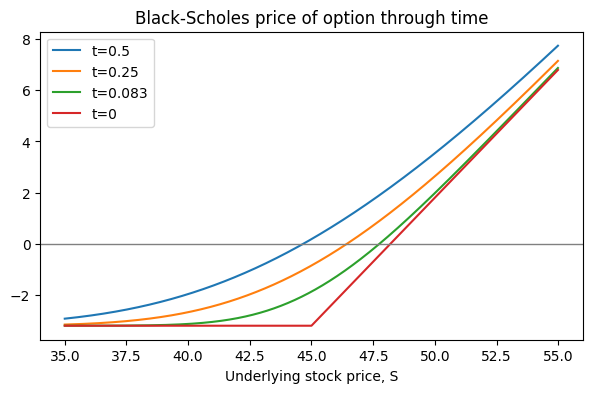

In [12]:
# plot the call payoffs
plt.figure(3, figsize=(7, 4))
plt.plot(S_, black_scholes_call_value_six_months)
plt.plot(S_, black_scholes_call_value_three_months)
plt.plot(S_, black_scholes_call_value_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.axhline(y=0, lw=1, c="grey")
plt.title("Black-Scholes price of option through time")
plt.xlabel("Underlying stock price, S")
plt.legend(["t=0.5", "t=0.25", "t=0.083", "t=0"], loc=2)

Comme le montre le graphique ci\-dessus, à mesure que le délai avant l'expiration diminue, la valeur de l'option s'effondre et se rapproche de la valeur de l'option à l'expiration, ou valeur du payoff.  



# The Greeks

Une discussion sur Black\-Scholes ne serait pas complète sans une discussion sur les grecques. En termes mathématiques, les grecques sont simplement les dérivées partielles de la formule de calcul du prix de l'option. En d'autres termes, il s'agit des sensibilités dans le mouvement du prix de l'option par rapport au mouvement d'autres aspects des variables d'entrée.

Étant donné que les hypothèses requises pour le modèle Black\-Scholes ne se vérifient pas dans la pratique, la formule simple présentée ci\-dessus n'est généralement pas utilisée pour fixer le prix des options à des fins de négociation. \(En fait, si quelqu'un devait se fier à Black\-Scholes pour gérer un portefeuille d'options, ce trader perdrait certainement de l'argent\). Elle est toutefois largement utilisée pour comprendre les sensibilités de l'option par rapport à ses paramètres et pour se couvrir. Les grecques les plus courantes sont les suivantes.

- **Delta**. Dérivée partielle de la valeur de l'option par rapport à la variation du prix de l'action sous\-jacente. Le delta mesure l'évolution de l'option sous\-jacente par rapport à l'évolution de l'action sous\-jacente. La formule du delta est différente pour les options d'achat et les options de vente.

> Call delta
> $$\frac{\partial V}{\partial S} = N(d_{1})$$

> Put delta
> $$\frac{\partial V}{\partial S} = N(d_{1})-1$$

- **Gamma**. Deuxième dérivée partielle de la valeur de l'option par rapport à la variation du prix de l'action sous\-jacente. Le gamma mesure les mouvements du delta ou la convexité de la valeur de l'option par rapport au sous\-jacent.  

> Gamma \(same for call and put\)
> $$\frac{\partial^2 V}{\partial S^2} = \frac{\phi(d_{1})}{S\sigma \sqrt{T-t}}$$

- **Vega**. Dérivée partielle de la valeur de l'option par rapport à la variation de la volatilité du sous\-jacent. Vega mesure l'évolution du prix de l'option par rapport à la volatilité du sous\-jacent. \(Remarque : Vega n'est pas une vraie lettre grecque\).  

> Vega (same for call and put)
> $$\frac{\partial V}{\partial \sigma} = S\phi(d_{1}) \sqrt{T-t}$$

- **Theta**. Dérivée partielle de la valeur de l'option par rapport au changement de temps. Le thêta mesure la façon dont la valeur de l'option diminue au fil du temps. Ceci a été démontré dans le graphique ci\-dessus.

> Call theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} -rKe^{-r(T-t)}N(d_2)$$

> Put theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} +rKe^{-r(T-t)}N(-d_2)$$

- **Rho**. Dérivée partielle de la valeur de l'option par rapport à la variation du taux d'intérêt sans risque. Rho mesure l'évolution de la valeur de l'option en fonction de la variation du taux d'intérêt.

> Call rho
> $$\frac{\partial V}{\partial r} = K(T-t)e^{-r(T-t)}N(d_2)$$

> Put rho
> $$\frac{\partial V}{\partial r} = -K(T-t)e^{-r(T-t)}N(-d_2)$$

où $\phi$

> $$\phi(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$$

et N\(.\), d1 et d2 sont définis plus tôt  
.


# The Greeks in Python

Même si nous ne discuterons plus des greeks dans cet exposé, codons\-les par souci d'exhaustivité.  



In [13]:
# helper function phi
def phi(x):
    """ Phi helper function
    
    """
    return np.exp(-0.5 * x * x) / (sqrt(2.0 * pi))


# shared
def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return phi(d1) / (S * vol * sqrt(t))


def vega(S, K, r, t, vol):
    """ Black-Scholes vega
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return (S * phi(d1) * sqrt(t)) / 100.0


# call options
def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return N(d1)

In [14]:
def call_theta(S, K, r, t, vol):
    """ Black-Scholes call theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - (
        r * K * np.exp(-r * t) * N(d2)
    )
    return theta / 365.0


def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0


# put options
def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return N(d1) - 1.0

In [15]:
def put_theta(S, K, r, t, vol):
    """ Black-Scholes put theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + (
        r * K * np.exp(-r * t) * N(-d2)
    )
    return theta / 365.0


def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0

In [16]:
# print each of the results
print("Black-Scholes call delta %0.4f" % call_delta(S, K, r, t, vol))
print("Black-Scholes put delta %0.4f" % put_delta(S, K, r, t, vol))
print("Black-Scholes gamma %0.4f" % gamma(S, K, r, t, vol))
print("Black-Scholes vega %0.4f" % vega(S, K, r, t, vol))
print("Black-Scholes call theta %0.4f" % call_theta(S, K, r, t, vol))
print("Black-Scholes put theta %0.4f" % put_theta(S, K, r, t, vol))
print("Black-Scholes call rho %0.4f" % call_rho(S, K, r, t, vol))
print("Black-Scholes put rho %0.4f" % put_rho(S, K, r, t, vol))

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


# Realized Volatility

Également appelée volatilité historique ou statistique, la volatilité réalisée estime la volatilité du prix sous\-jacent sur une période de temps définie. Elle est généralement utilisée comme donnée d'entrée dans un modèle d'évaluation tel que le modèle Black\-Scholes pour calibrer la valeur et résoudre ensuite la volatilité implicite. La volatilité réalisée n'est généralement pas utilisée pour prendre des décisions de trading, mais elle peut être utile pour comprendre comment le sous\-jacent a évolué dans le passé.

Le cours bonus présente plusieurs estimateurs de la volatilité réalisée. Nous utiliserons ici l'estimateur le plus courant, à savoir l'écart\-type simple des rendements logarithmiques. Une technique d'analyse populaire, les cônes de volatilité, est également présentée.

Nous utiliserons pandas\_datareader pour obtenir les prix historiques du sous\-jacent et calculer une mesure de la volatilité annualisée sur 30 jours.  



In [17]:
# define a stock symbol
underlying_symbol = "AAPL"

# get data
prices = obb.equity.price.historical(underlying_symbol, provider="yfinance")

# yahoo returns prices in ascending order, sort to descending order
prices.sort_index(ascending=False, inplace=True)

# let's pickle the dataframe so we don't have to hit the network every time
prices.to_pickle("underlying_prices.pickle")

In [18]:
# read the original frame in from cache (pickle)
prices = pd.read_pickle("underlying_prices.pickle")

<Axes: xlabel='date'>

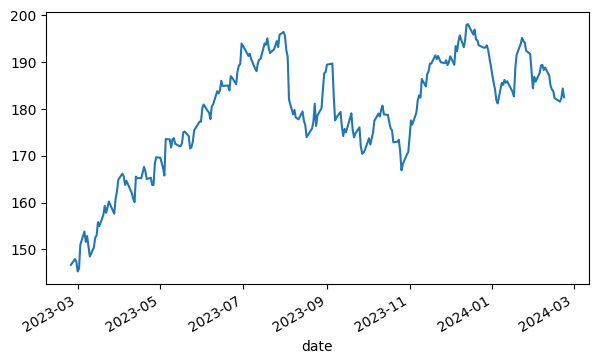

In [19]:
prices.close.plot(figsize=(7, 4))

Utilisez le dernier mois \(environ 22 jours de bourse\) de l'ensemble de données pour calculer  



In [20]:
# compute the log returns from the adjusted closing price
log_return = (prices.close / prices.close.shift(-1)).apply(np.log)

# take the standard deviation of the last month of data (22 trading days)
sd_of_log_returns = log_return.head(22).std()

# multiply by the square root of the number of trading days in a year (252) to annualize
realized_volatility = sd_of_log_returns * sqrt(252)

In [21]:
print("One month, annualized realized volatility %0.4f" % realized_volatility)

One month, annualized realized volatility 0.1407


In [22]:
# use the pandas DataFrame.rolling method to create a rolling standard deviation of 
# log returns, then multiply by square root of 252 to annualize
rolling_realized_volatility = log_return.rolling(window=22, center=False).std() * sqrt(
    252
)

<Axes: title={'center': 'Historic one month, annualized realized volatility'}, xlabel='date'>

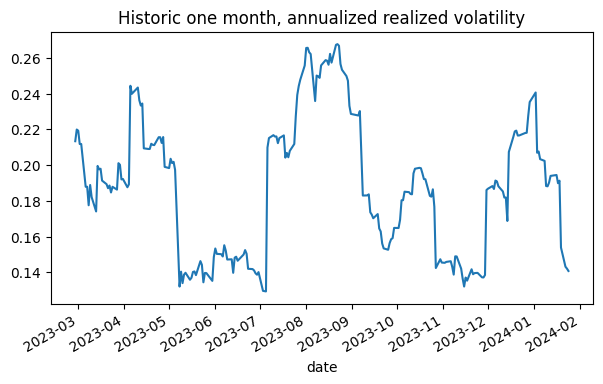

In [23]:
# note that we plot plot directly from a pandas data frame!
rolling_realized_volatility.plot(
    title="Historic one month, annualized realized volatility", figsize=(7, 4)
)

# Implied Volatility

La formule d'évaluation de Black\-Scholes est généralement utilisée pour déterminer la volatilité implicite. En termes simples, cela signifie que la formule d'évaluation de Black\-Scholes est égale au prix observé sur le marché et qu'un algorithme de recherche de racine est utilisé pour résoudre le paramètre de volatilité qui fixe la différence \(entre le modèle et le prix du marché\) à zéro.

La volatilité implicite est généralement utilisée pour prendre des décisions de trading, calibrer d'autres titres plus exotiques et étudier les anomalies du marché. Par exemple, de nombreux traders utilisent ce que l'on appelle l'asymétrie de la volatilité pour comprendre la valeur relative d'une option par rapport à d'autres options négociées sur le marché. Nous verrons plus loin des exemples de skew.

Nous commençons par créer une fonction objective que nous transmettrons à l'implémentation Scipy de l'algorithme de Brentq. Ensuite, nous créons une fonction de volatilité implicite pour renvoyer le paramètre de volatilité qui définit le prix du marché observé par rapport au prix du modèle.  



In [24]:
def call_implied_volatility_objective_function(
    S, K, r, t, vol, call_option_market_price
):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

In [25]:
def call_implied_volatility(
    S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
    """ Call implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    # avoid mirroring outer scope
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price

    # define a nested function that takes our target param as the input
    def fcn(vol):

        # returns the difference between market and model price at given volatility
        return call_implied_volatility_objective_function(
            _S, _K, _r, _t, vol, _call_option_market_price
        )

    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)

        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result

    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

    
def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

In [26]:
def put_implied_volatility(
    S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
    """ Put implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """

    # avoid mirroring out scope
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price

    # define a nsted function that takes our target param as the input
    def fcn(vol):

        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(
            _S, _K, _r, _t, vol, _put_option_market_price
        )

    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)

        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result

    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

In [27]:
# get the call and put values to test the implied volatility output
call_model_price = black_scholes_call_value(S, K, r, t, vol)
print(
    "Call implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % call_implied_volatility(S, K, r, t, call_model_price)
)

put_model_price = black_scholes_put_value(S, K, r, t, vol)
print(
    "Put implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % put_implied_volatility(S, K, r, t, put_model_price)
)

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


# Getting Real Options Market Data

Avec l'excellente bibliothèque yfinance, nous pouvons récupérer des chaînes d'options entières directement à partir de Yahoo ! C'est lent \(il faut gratter plusieurs pages\), mais très utile. Les chaînes comprennent toutes les options de tous les strikes et de toutes les expirations pour une action sous\-jacente particulière.

Les chaînes sont renvoyées dans un objet pandas.DataFrame très pratique. Voyons comment cela fonctionne.  



In [28]:
def option_chains(ticker):
    """
    """
    chains = obb.derivatives.options.chains(ticker)

    chains.expiration = pd.to_datetime(
        chains.expiration,
        utc=True
    )
    
    chains['underlying_symbol'] = ticker
    
    return chains

In [29]:
# define a Options object
options_obj = option_chains(underlying_symbol)

# add the last underlying price
options_obj['underlying_price'] = obb.equity.price.quote(underlying_symbol).iloc[0].last_price

# let's pickle the dataframe so we don't have to hit the network every time
options_obj.to_pickle('options_frame.pickle')

In [30]:
# read the original frame in from cache (pickle)
options_frame = pd.read_pickle("options_frame.pickle")

In [31]:
# take a quick look at the DataFrame that returned
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2364 entries, 0 to 2363
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   contract_symbol       2364 non-null   object             
 1   expiration            2364 non-null   datetime64[ns, UTC]
 2   strike                2364 non-null   float64            
 3   option_type           2364 non-null   object             
 4   open_interest         2364 non-null   int64              
 5   volume                2364 non-null   int64              
 6   theoretical_price     2364 non-null   float64            
 7   last_trade_price      2364 non-null   float64            
 8   tick                  2364 non-null   object             
 9   bid                   2364 non-null   float64            
 10  bid_size              2364 non-null   int64              
 11  ask                   2364 non-null   float64            
 12  ask_si

In [32]:
# and the first ten records
options_frame.head()

,contract_symbol,expiration,strike,option_type,open_interest,volume,theoretical_price,last_trade_price,tick,bid,...,implied_volatility,delta,gamma,theta,vega,rho,last_trade_timestamp,dte,underlying_symbol,underlying_price
0,AAPL240223C00095000,2024-02-23 00:00:00+00:00,95.0,call,12,4,87.4808,89.24,down,86.60,...,0.0,1.0000,0.0,-0.0002,0.0,0.0001,2024-02-23 09:59:15,-1,AAPL,182.28
1,AAPL240223P00095000,2024-02-23 00:00:00+00:00,95.0,put,66,0,0.0003,0.01,no_change,0.00,...,0.0,0.0000,0.0,-0.0003,0.0,0.0000,2024-02-16 10:28:24,-1,AAPL,182.28
2,AAPL240223C00100000,2024-02-23 00:00:00+00:00,100.0,call,10,7,82.4809,82.57,up,81.55,...,0.0,1.0000,0.0,-0.0003,0.0,0.0001,2024-02-23 12:43:56,-1,AAPL,182.28
3,AAPL240223P00100000,2024-02-23 00:00:00+00:00,100.0,put,920,0,0.0003,0.01,no_change,0.00,...,0.0,0.0000,0.0,-0.0003,0.0,0.0000,2024-02-21 09:47:19,-1,AAPL,182.28
4,AAPL240223C00105000,2024-02-23 00:00:00+00:00,105.0,call,1,0,77.4809,79.35,up,76.60,...,0.0,0.9999,0.0,-0.0004,0.0,0.0001,2024-02-22 15:55:00,-1,AAPL,182.28


Définissons quelques fonctions d'aide que nous appliquerons au DataFrame. Elles fourniront certaines des données d'entrée aux fonctions d'évaluation des options.  



In [33]:
def _get_time_fraction_until_expiration(series):
    """ Return the fraction of a year until expiration
    
    You don't always have to be this precise. The difference in price
    based on a few hours for long dated options or far OTM options
    will not be affected. However for liquid, ATM options with short
    expiration windows, every second counts!

    :param series: row of the dataframe, accessible by label
    :return: fraction of a year until expiration

    """

    expiration = series["expiration"]

    # add the hours to the expiration date so we get the math correct
    date_str = expiration.strftime("%Y-%m-%d") + " 23:59:59"

    # convert date string into datetime object
    time_tuple = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")

    # get the number of seconds from the epoch until expiration
    expiry_in_seconds_from_epoch = time.mktime(time_tuple)

    # get the number of seconds from the epoch to right now
    today = dt.datetime.today()
    right_now_in_seconds_from_epoch = time.time()

    # get the total number of seconds to expiration
    seconds_until_expiration = (
        expiry_in_seconds_from_epoch - right_now_in_seconds_from_epoch
    )

    # seconds in year
    seconds_in_year = 31536000.0

    # fraction of seconds to expiration to total in year, rounded
    return max(seconds_until_expiration / seconds_in_year, 1e-10)

In [34]:
# define terms and associated rates, these should coincide with our options
# these rates are taken from the yield curve
terms = [30, 3 * 30, 6 * 30, 12 * 30, 24 * 30, 36 * 30, 60 * 30]
rates = [0.0001, 0.0009, 0.0032, 0.0067, 0.0097, 0.0144, 0.0184]


def _get_rate(series):
    """ Interpolate rates out to 30 years
        Note computing rates like this is not strictly theoretically 
        correct but works for illustrative purposes
    
    :param series: row of the dataframe, accessable by label
    :return interpolated interest rate based on term structure

    """
    days = series["dte"]

    # generate terms for every thirty days up until our longest expiration
    new_terms = [i for i in range(30, (60 * 30) + 1)]

    # create linear interpolation model
    f = interp1d(terms, rates, kind="linear")

    # interpolate the values based on the new terms we created above
    ff = f(new_terms)

    # return the interpolated rate given the days to expiration
    return round(ff[max(days, 30) - 30], 8)


def _get_mid(series):
    """ Get the mid price between bid and ask
    
    :param series: row of the dataframe, accessable by label
    :return mid price

    """
    bid = series["bid"]
    ask = series["ask"]
    last = series["last_trade_price"]

    # if the bid or ask doesn't exist, return 0.0
    if np.isnan(ask) or np.isnan(bid):
        return 0.0

    # if the bid or ask are 0.0, return the last traded price
    elif ask == 0.0 or bid == 0.0:
        return last
    else:
        return (ask + bid) / 2.0

Nous pouvons appliquer ces fonctions à chaque ligne du DataFrame en définissant l'argument axis à 1 apply method.  



In [35]:
# use the apply method to pass each row as a series to the various methods, returns a series in this case
options_frame["time_until_expiration"] = options_frame.apply(
    _get_time_fraction_until_expiration, axis=1
)
options_frame["interest_rate"] = options_frame.apply(_get_rate, axis=1)
options_frame["mid"] = options_frame.apply(_get_mid, axis=1)

Let's see what we've done.

In [36]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2364 entries, 0 to 2363
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   contract_symbol        2364 non-null   object             
 1   expiration             2364 non-null   datetime64[ns, UTC]
 2   strike                 2364 non-null   float64            
 3   option_type            2364 non-null   object             
 4   open_interest          2364 non-null   int64              
 5   volume                 2364 non-null   int64              
 6   theoretical_price      2364 non-null   float64            
 7   last_trade_price       2364 non-null   float64            
 8   tick                   2364 non-null   object             
 9   bid                    2364 non-null   float64            
 10  bid_size               2364 non-null   int64              
 11  ask                    2364 non-null   float64          

# Applying Implied Volatility

Nous disposons maintenant de tous les paramètres d'entrée dont nous avons besoin pour suivre la même procédure afin d'ajouter le prix de Black\-Scholes et les greeks associés. Nous commencerons comme précédemment par définir les fonctions que nous appliquerons. Notez que nous devons d'abord calculer la volatilité implicite, que nous utiliserons comme vol d'entrée dans la formule de Black\-Scholes. Il est courant d'utiliser la formule de Black\-Scholes pour calculer la volatilité implicite, puis d'utiliser ce résultat pour calculer les greeks.

Nous prendrons le prix moyen \(prix entre l'offre et la demande\) car il est généralement considéré comme le prix le plus représentatif à utiliser. Comme nous le verrons, il y aura des problèmes avec le résultat que nous devrons nettoyer.  



In [37]:
def _get_implied_vol_mid(series):
    """

    """
    option_type = series["option_type"]
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    mid = series["mid"]

    # build method name
    meth_name = "{0}_implied_volatility".format(option_type)

    # call from globals()
    return float(globals().get(meth_name)(S, K, r, t, mid))

In [38]:
# apply the function to the dataframe rowwise
options_frame["implied_volatility_mid"] = options_frame.apply(
    _get_implied_vol_mid, axis=1
)

In [39]:
# again, let's take a look
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2364 entries, 0 to 2363
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   contract_symbol         2364 non-null   object             
 1   expiration              2364 non-null   datetime64[ns, UTC]
 2   strike                  2364 non-null   float64            
 3   option_type             2364 non-null   object             
 4   open_interest           2364 non-null   int64              
 5   volume                  2364 non-null   int64              
 6   theoretical_price       2364 non-null   float64            
 7   last_trade_price        2364 non-null   float64            
 8   tick                    2364 non-null   object             
 9   bid                     2364 non-null   float64            
 10  bid_size                2364 non-null   int64              
 11  ask                     2364 non-null   flo

# Interpolating Missing and Bad Implied Volatility Values

Dans les fonctions call\_implied\_volatility et put\_implied\_volatility, nous testons si le solveur Brentq explose. Le solveur saute si le prix moyen de l'option conduit à une volatilité implicite négative. Cela se produit avec des options profondément dans la monnaie ou hors de la monnaie, lorsque les teneurs de marché maintiennent l'écart entre les cours acheteur et vendeur à un niveau élevé.

Trouvons les options dont la volatilité implicite est np.nan.  



In [40]:
bad_iv = options_frame[np.isnan(options_frame["implied_volatility_mid"])]

In [41]:
# map the count function to each strike where there is a nan implied volatility
bad_iv.groupby(["strike"]).count()["expiration"]

strike
5.0      6
10.0     4
15.0     4
20.0     3
25.0     3
        ..
290.0    3
295.0    2
300.0    3
310.0    2
320.0    1
Name: expiration, Length: 71, dtype: int64

Nous allons maintenant interpoler les valeurs manquantes de volatilité implicite. Il existe des méthodes beaucoup plus sophistiquées pour ce faire \(voir ici par exemple\). En fait, c'est là que les traders d'options professionnels gagnent de l'argent. Les entreprises dépensent des millions de dollars pour élaborer des modèles plus performants que ceux de leurs concurrents.

Nous utiliserons une simple interpolation linéaire pour démontrer la technique.

Nous commencerons par définir la fonction à laquelle nous transmettrons le cadre.  



In [42]:
def _interp_implied_volatility(options_frame):
    """ Interpolate missing (np.nan) values of implied volatility
    We first need to split the chains into expiration and type because we cannot
    interpolate across the entire chain, rather within these two groups
    
    :param options_frame: DataFrame containing options data
    :return original DataFrame with ImpliedVolatilityMid column containing interpolated values

    """
    # create a MultiIndex with Expiration, OptionType, the Strike as index, then sort
    frame = options_frame.set_index(["expiration", "option_type", "strike"]).sort_index()

    # pivot the frame with ImpliedVolatilityMid as the values within the table
    # this has Strikes along the rows and Expirations along the columns
    # the level=1 unstack pivots on OptionType and level=0 unstack pivots on Expiration
    unstacked = frame["implied_volatility_mid"].unstack(level=1).unstack(level=0)

    # this line does three things:
    #    first interpolates across each Expiration date down the strikes for np.nan values
    #    second forward fills values which keeps the last interpolated value as the value to fill
    #    third back fills values which keeps the first interpolated value as the value to fill
    unstacked_interp = unstacked.interpolate().ffill().bfill()

    # restack into shape of original DataFrame
    unstacked_interp_indexed = (
        unstacked_interp.stack(level=0).stack(level=0).reset_index()
    )

    # replace old column with the new column with interpolated and filled values
    frame["implied_volatility_mid"] = unstacked_interp_indexed.set_index(
        ["expiration", "option_type", "strike"]
    )

    # give our index back
    frame.reset_index(inplace=True)

    # where we cannot interpolate, drop
    return frame.dropna()

In [43]:
# get the completed frame
options_frame = _interp_implied_volatility(options_frame)

# Applying Black-Scholes and the greeks

Avant d'examiner la volatilité implicite, appliquons la formule de Black\-Scholes et les grecs associés. Définissons d'abord les fonctions que nous appliquerons au cadre.  



In [44]:
def _get_option_value(series):
    """ Return the option value given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: Black-Scholes option value

    """
    option_type = series["option_type"]
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    meth_name = "black_scholes_{0}_value".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))


def _get_delta(series):
    """ Return the option delta given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option delta

    """
    option_type = series["option_type"]
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    meth_name = "{0}_delta".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))


def _get_gamma(series):
    """ Return the option gamma

    :param series: row of the dataframe, accessible by label
    :return: option gamma

    """
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    return float(gamma(S, K, r, t, vol))

In [45]:
def _get_vega(series):
    """ Return the option vega

    :param series: row of the dataframe, accessible by label
    :return: option vega

    """
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    return float(vega(S, K, r, t, vol))


def _get_theta(series):
    """ Return the option theta given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option theta

    """
    option_type = series["option_type"]
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    meth_name = "{0}_theta".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))


def _get_rho(series):
    """ Return the option rho given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option rho

    """
    option_type = series["option_type"]
    S = series["underlying_price"]
    K = series["strike"]
    r = series["interest_rate"]
    t = series["time_until_expiration"]
    vol = series["implied_volatility_mid"]

    meth_name = "{0}_rho".format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

In [46]:
def _get_model_error(series):
    """ Return the error between mid price and model price

    :param series: row of the dataframe, accessible by label
    :return: error between mid price and model price

    """
    option_mid = series["mid"]

    return option_mid - _get_option_value(series)

# use the apply method to pass each row as a series to the various methods, returns a series in this case
options_frame["value"] = options_frame.apply(_get_option_value, axis=1)
options_frame["computed_delta"] = options_frame.apply(_get_delta, axis=1)
options_frame["computed_gamma"] = options_frame.apply(_get_gamma, axis=1)
options_frame["computed_vega"] = options_frame.apply(_get_vega, axis=1)
options_frame["computed_theta"] = options_frame.apply(_get_theta, axis=1)
options_frame["computed_rho"] = options_frame.apply(_get_rho, axis=1)
options_frame["computed_model_error"] = options_frame.apply(_get_model_error, axis=1)

In [47]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1857 entries, 98 to 2363
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   expiration              1857 non-null   datetime64[ns, UTC]
 1   option_type             1857 non-null   object             
 2   strike                  1857 non-null   float64            
 3   contract_symbol         1857 non-null   object             
 4   open_interest           1857 non-null   int64              
 5   volume                  1857 non-null   int64              
 6   theoretical_price       1857 non-null   float64            
 7   last_trade_price        1857 non-null   float64            
 8   tick                    1857 non-null   object             
 9   bid                     1857 non-null   float64            
 10  bid_size                1857 non-null   int64              
 11  ask                     1857 non-null   float64

# Analyzing the Model Error

Il est utile de visualiser certaines des données que nous avons créées. Un analyste quantitatif doit essentiellement être un analyste/développeur complet qui comprend les implications des modèles d'évaluation et des métriques. Il y a trois ans, on appelait cela la recherche quantitative. Aujourd'hui, on parle de science des données.

Nous commencerons simplement par situer l'erreur de modèle. Étant donné que nous avons calculé la volatilité implicite à partir de la formule de Black\-Scholes et que nous avons utilisé ce résultat pour fixer le prix de l'option, on peut s'attendre à ce qu'il n'y ait pas d'erreur de modèle.

Comme vous pouvez le voir dans l'histogramme, ce n'est pas le cas. En fait, à plusieurs reprises, l'erreur de modèle est relativement importante.  



<Axes: >

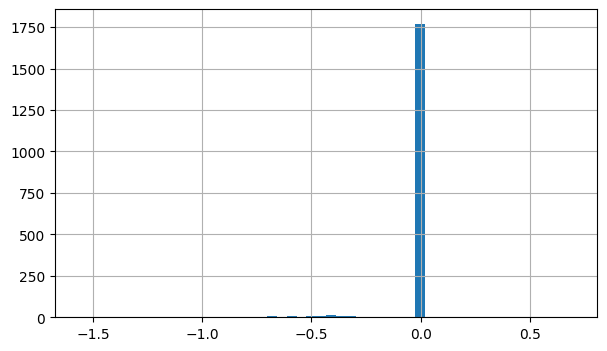

In [48]:
# plot the model error
options_frame["computed_model_error"].hist(bins=50, figsize=(7, 4))

Quelle est l'explication ?

Sur la base de certains de mes commentaires ci\-dessus, notre hypothèse devrait être que les options très en dedans ou en   
dehors de la monnaie présentent généralement des écarts importants entre les cours acheteur et vendeur, ce qui entraîne un bad pricing des options. Représentons l'écart entre le prix d'exercice et l'erreur de modèle.


<Axes: xlabel='strike'>

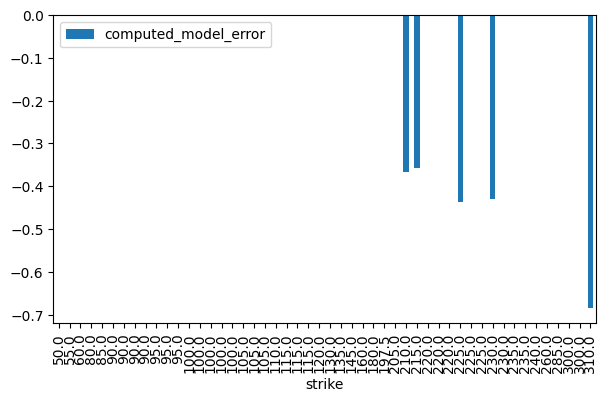

In [49]:
# grab the index of the 50 largest abs(errors)
sorted_errors_idx = (
    options_frame["computed_model_error"].map(abs).sort_values(ascending=False).head(50)
)

# get the rest of the details from the frame
errors_20_largest_by_strike = options_frame.iloc[sorted_errors_idx.index]

# plot model error against strike
errors_20_largest_by_strike[["strike", "computed_model_error"]].sort_values(by="strike").plot(
    kind="bar", x="strike", figsize=(7, 4)
)

Nous pouvons également étudier comment l'écart entre les cours acheteur et vendeur contribue à l'erreur de modélisation.  



<Axes: xlabel='bid_ask_spread'>

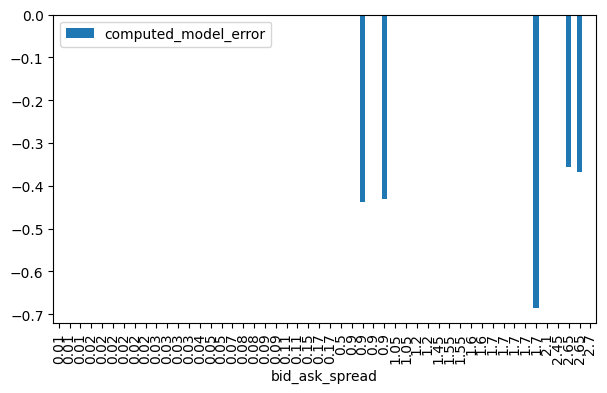

In [50]:
# add a new column
options_frame["bid_ask_spread"] = (options_frame["ask"] - options_frame["bid"]).round(4)

# plot model error by bid-ask spread
errors_20_largest_by_spread = options_frame.iloc[sorted_errors_idx.index]

# plot model error against strike, many expirations included
errors_20_largest_by_spread[["bid_ask_spread", "computed_model_error"]].sort_values(
    by="bid_ask_spread"
).plot(kind="bar", x="bid_ask_spread", figsize=(7, 4))

Enfin, examinons la relation entre l'erreur de modèle et l'écart entre les cours acheteur et vendeur.  



<Axes: xlabel='bid_ask_spread', ylabel='computed_model_error'>

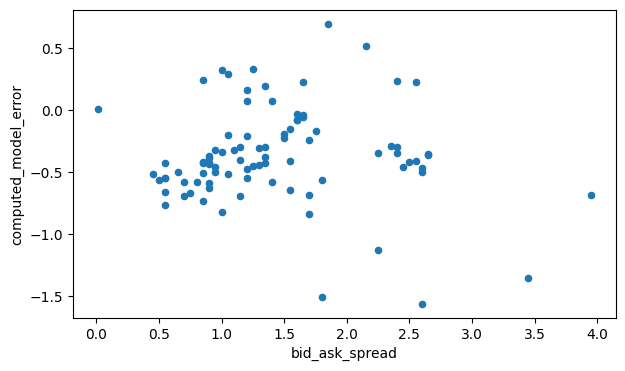

In [51]:
# plot a scatter plot of all errors > 1.0e-4
options_frame[abs(options_frame["computed_model_error"]) >= 1.0e-4].plot(
    kind="scatter", x="bid_ask_spread", y="computed_model_error", figsize=(7, 4)
)

Il n'y a pas assez d'échantillons pour obtenir une quelconque relation statistique, mais nous pouvons clairement voir que lorsque l'écart entre les cours acheteur et vendeur augmente, l'erreur du modèle augmente également.  



# Analyzing Implied Volatility

Nous examinerons tout d'abord ce que l'on appelle l'asymétrie de la volatilité implicite. Ce graphique représente la volatilité implicite pour une échéance en fonction des prix d'exercice. Toutes choses étant égales par ailleurs, une option dont la volatilité implicite est plus élevée sera plus chère. En règle générale, les prix d'exercice des options "deep in" et "out of the money" sont plus élevés \(et, par conséquent, les volatilités implicites plus élevées\) que ne le prévoit la formule de Black\-Scholes. Cette asymétrie n'a commencé à apparaître qu'après l'effondrement des actions américaines en octobre 1987. On suppose que cela est dû au fait que les hypothèses de distribution sous\-jacentes ont des "queues grasses" au lieu d'être tout à fait normales.

Voyons ce qu'il en est.  



In [52]:
expirations = set(options_frame.expiration)
expirations

{Timestamp('2024-03-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-08 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-15 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-22 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-28 00:00:00+0000', tz='UTC'),
 Timestamp('2024-04-05 00:00:00+0000', tz='UTC'),
 Timestamp('2024-04-19 00:00:00+0000', tz='UTC'),
 Timestamp('2024-05-17 00:00:00+0000', tz='UTC'),
 Timestamp('2024-06-21 00:00:00+0000', tz='UTC'),
 Timestamp('2024-07-19 00:00:00+0000', tz='UTC'),
 Timestamp('2024-08-16 00:00:00+0000', tz='UTC'),
 Timestamp('2024-09-20 00:00:00+0000', tz='UTC'),
 Timestamp('2024-10-18 00:00:00+0000', tz='UTC'),
 Timestamp('2024-11-15 00:00:00+0000', tz='UTC'),
 Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 Timestamp('2025-01-17 00:00:00+0000', tz='UTC'),
 Timestamp('2025-03-21 00:00:00+0000', tz='UTC'),
 Timestamp('2025-06-20 00:00:00+0000', tz='UTC'),
 Timestamp('2025-09-19 00:00:00+0000', tz='UTC'),
 Timestamp('2025-12-19 00:00:00+0000', tz='UTC'),


In [53]:
exp = list(expirations)[5]

<Axes: title={'center': 'Implied volatility skew'}, xlabel='strike'>

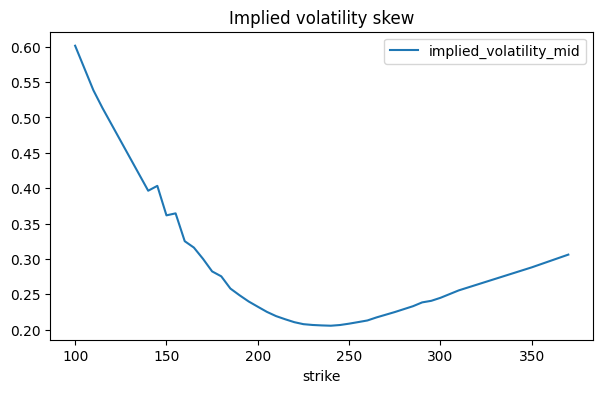

In [54]:
# select an expiration to plot
iv = options_frame[options_frame["expiration"] == exp]

# get the call options
iv_call = iv[iv["option_type"] == "call"]

# set the strike as the index so pandas plots nicely
iv_call[["strike", "implied_volatility_mid"]].set_index("strike").plot(
    title="Implied volatility skew", figsize=(7, 4)
)

La courbe montre que les strikes at the money ont une volatilité implicite plus élevée que les strikes at the money. C'est un peu inhabituel mais très probablement dû à l'état général de la volatilité du marché. Les traders fixent le prix des options d'achat à la monnaie beaucoup plus élevé que celui des options d'achat hors monnaie, en raison de la demande d'options d'achat au prix d'exercice de 130 dollars.

Dans un cadre professionnel, les traders utiliseraient des modèles propriétaires \(et non une simple interpolation linéaire\) pour reconstruire les courbes. Si le modèle propriétaire aboutit à une volatilité implicite supérieure à celle du marché, une transaction est exécutée pour exploiter l'anomalie. Dans notre cas, nous visualisons simplement l'état actuel du marché.

Une autre analyse intéressante consiste à examiner le graphique de l'asymétrie de l'expiration multiple.  



<Axes: xlabel='strike'>

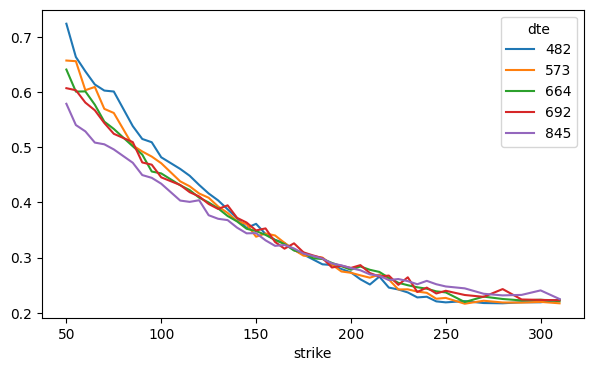

In [55]:
# get the monthly expirations
expirations = options_frame["expiration"].unique()[-5:]

# get all the rows where expiration is in our list of expirations
iv_multi = options_frame[options_frame["expiration"].isin(expirations)]

# get the call options
iv_multi_call = iv_multi[iv_multi["option_type"] == "call"]

# pivot the data frame to put expiration dates as columns
iv_pivoted = (
    iv_multi_call[["dte", "strike", "implied_volatility_mid"]]
    .pivot(index="strike", columns="dte", values="implied_volatility_mid")
    .dropna()
)

# plot
iv_pivoted.plot(figsize=(7, 4))

Nous allons maintenant examiner la structure par terme de la volatilité. Celle\-ci mesure la volatilité implicite pour un prix d'exercice donné \(généralement un prix d'exercice à la monnaie\), mais pour plusieurs échéances. À l'instar des concepts de backwardization et de contango sur les marchés à terme, la structure par terme donne une idée de la demande d'options à un moment donné dans le futur.  



<Axes: title={'center': 'Volatility term structure'}, xlabel='expiration'>

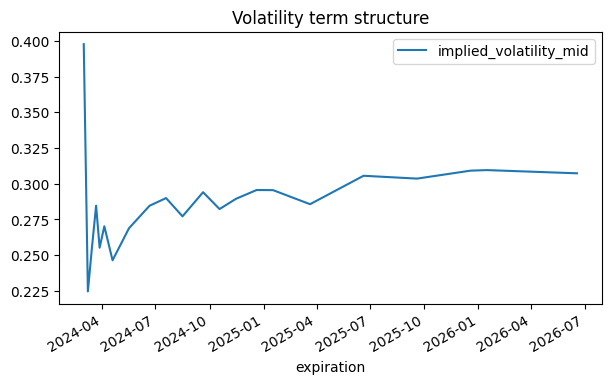

In [56]:
# select a strike to plot
iv = options_frame[options_frame["strike"] == 175.0]

# get the call options
iv_call = iv[iv["option_type"] == "call"]

# set the strike as the index so pandas plots nicely
iv_call[["expiration", "implied_volatility_mid"]].set_index("expiration").plot(
    title="Volatility term structure",
    figsize=(7, 4)
)

Il s'agit d'une démonstration claire de la violation des affirmations du modèle Black\-Scholes. Une structure à terme de volatilité plate n'existe pas sur les marchés et nous avons les preuves empiriques pour le prouver.

Sur le strike 170\$, l'implicite est très élevé à des échéances très proches. C'est le résultat de la récente volatilité du marché qui a augmenté la demande pour cette option.  



Une dernière chose à faire est de tracer la fameuse surface de volatilité. Celle\-ci donne une représentation en trois dimensions de la volatilité implicite en fonction du prix d'exercice et de l'échéance. Bien qu'il soit parfois difficile de tirer des informations exploitables directement de la surface, il est important de construire des surfaces pour évaluer d'autres produits dérivés qui peuvent ne pas avoir un prix d'exercice et une échéance exacts. Les traders professionnels peuvent donc concevoir leurs propres modèles de volatilité et utiliser la surface de volatilité implicite pour comprendre si les options sont bon marché ou chères.  



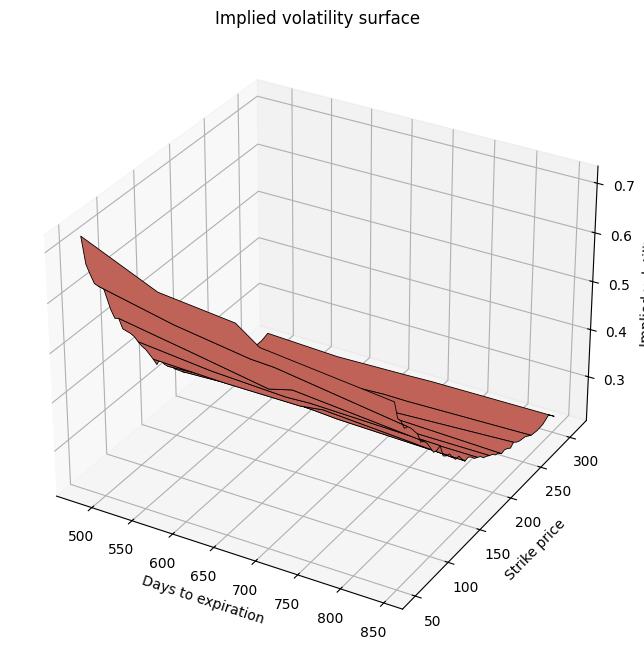

In [57]:
# pivot the dataframe
iv_pivoted_surface = (
    iv_multi_call[['dte', 'strike', 'implied_volatility_mid']]
    .pivot(
        index='strike',
        columns='dte',
        values='implied_volatility_mid'
    )
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = iv_pivoted_surface.columns.values, iv_pivoted_surface.index.values, iv_pivoted_surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Implied volatility surface')

# plot
ax.plot_surface(X, Y, z, rstride=4, cstride=4, color='salmon', edgecolors='k', lw=0.6)

End,

IB.  



# References

* http://pandas.pydata.org/pandas-docs/stable/index.html
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp1d.html
* http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.meshgrid.html
* http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
* http://nbviewer.ipython.org/github/quantopian/qgrid/blob/master/qgrid_demo.ipynb
* http://daringfireball.net/projects/markdown/syntax
* http://www.codecogs.com/latex/eqneditor.php
* http://www.bespokeoptions.com/blog/2015/10/06/implied-volatility-with-c-and-python-pt-1
* http://blog.nag.com/2013/10/implied-volatility-using-pythons-pandas.html
* http://www.888options.com
* https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
* https://en.wikipedia.org/wiki/Greeks_(finance)
* https://en.wikipedia.org/wiki/Volatility_smile
* http://pythonpodcast.com/scott-sanderson-algorithmic-trading.html
* http://pythonpodcast.com/yves-hilpisch-quant-finance.html

